In this tutorial, we will explore **concentration inequalities** — powerful mathematical tools to quantify how a random variable deviates from its expected value.

We will compare:
- (a) **Normal (Gaussian)** distributions with different means and variances,  
- (b) **Uniform** distributions,  
- (c) **Beta** distributions.

Then we will:
1. Estimate **confidence intervals** using **Hoeffding's** and **Chebyshev's** inequalities.  
2. Compare **empirical vs theoretical** coverage probabilities.  
3. Analyze which distributions obey the **68–95–99.7 empirical rule**.

---

📘 **References:**
- Hoeffding inequality: for bounded distributions  
- Chebyshev inequality: valid for all distributions  
- UIMP Quantum Machine Learning Course — Statistical Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, beta

# For reproducibility
np.random.seed(42)

In [2]:
def sample_distribution(dist_type, n=1000, **params):
    """Generate random samples from a given distribution."""
    if dist_type == 'normal':
        return np.random.normal(params.get('mu', 0), params.get('sigma', 1), n)
    elif dist_type == 'uniform':
        return np.random.uniform(params.get('a', 0), params.get('b', 1), n)
    elif dist_type == 'beta':
        return np.random.beta(params.get('alpha', 2), params.get('beta', 5), n)
    else:
        raise ValueError("Unknown distribution")

def hoeffding_bound(n, epsilon, a, b):
    """Compute Hoeffding's inequality upper bound."""
    return 2 * np.exp(-2 * n * epsilon**2 / (b - a)**2)

def chebyshev_bound(var, epsilon):
    """Compute Chebyshev's inequality upper bound."""
    return var / epsilon**2


In [3]:
# Parameters
n = 1000  # number of samples
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]

distributions = {
    'Normal(0,1)': ('normal', {'mu': 0, 'sigma': 1, 'a': -np.inf, 'b': np.inf}),
    'Uniform(0,1)': ('uniform', {'a': 0, 'b': 1}),
    'Beta(2,5)': ('beta', {'alpha': 2, 'beta': 5, 'a': 0, 'b': 1})
}

results = {}

for name, (dtype, params) in distributions.items():
    X = sample_distribution(dtype, n, **params)
    mean_emp = np.mean(X)
    var_emp = np.var(X)
    a, b = params.get('a', np.min(X)), params.get('b', np.max(X))

    probs = []
    for eps in epsilons:
        hoeff = hoeffding_bound(n, eps, a, b) if np.isfinite(a) and np.isfinite(b) else np.nan
        cheb = chebyshev_bound(var_emp, eps)
        probs.append((eps, hoeff, cheb))
    results[name] = {'mean': mean_emp, 'var': var_emp, 'bounds': probs}

results


{'Normal(0,1)': {'mean': np.float64(0.01933205582232549),
  'var': np.float64(0.9579049897315173),
  'bounds': [(0.1, nan, np.float64(95.79049897315171)),
   (0.2, nan, np.float64(23.94762474328793)),
   (0.3, nan, np.float64(10.643388774794637)),
   (0.4, nan, np.float64(5.986906185821982)),
   (0.5, nan, np.float64(3.831619958926069))]},
 'Uniform(0,1)': {'mean': np.float64(0.5036488055234082),
  'var': np.float64(0.08306651466417221),
  'bounds': [(0.1,
    np.float64(4.122307244877101e-09),
    np.float64(8.30665146641722)),
   (0.2, np.float64(3.6097027756907793e-35), np.float64(2.076662866604305)),
   (0.3, np.float64(1.3428368576423187e-78), np.float64(0.922961274046358)),
   (0.4, np.float64(2.1222463074925815e-139), np.float64(0.5191657166510762)),
   (0.5,
    np.float64(1.4249152813482571e-217),
    np.float64(0.33226605865668885))]},
 'Beta(2,5)': {'mean': np.float64(0.28774807886409304),
  'var': np.float64(0.025373144070951988),
  'bounds': [(0.1,
    np.float64(4.1223072

In [4]:
import pandas as pd

def theoretical_variance(dist_name, params):
    """Compute the theoretical variance of a given distribution if known."""
    if dist_name == 'normal':
        return params['sigma']**2
    elif dist_name == 'uniform':
        a, b = params['a'], params['b']
        return (b - a)**2 / 12
    elif dist_name == 'beta':
        α, β = params['alpha'], params['beta']
        return (α * β) / (((α + β)**2) * (α + β + 1))
    else:
        return np.nan

# Build DataFrame of results
var_summary = []
for name, (dtype, params) in distributions.items():
    X = sample_distribution(dtype, n, **params)
    var_emp = np.var(X)
    var_th = theoretical_variance(dtype, params)
    var_summary.append({
        'Distribution': name,
        'Variance (Empirical)': var_emp,
        'Variance (Theoretical)': var_th,
        'Bounded?': 'Yes' if np.isfinite(params.get('a', -np.inf)) and np.isfinite(params.get('b', np.inf)) else 'No'
    })

df_vars = pd.DataFrame(var_summary)
display(df_vars.round(6))

,Distribution,Variance (Empirical),Variance (Theoretical),Bounded?
0,"Normal(0,1)",1.022232,1.000000,No
1,"Uniform(0,1)",0.078589,0.083333,Yes
2,"Beta(2,5)",0.024339,0.025510,Yes


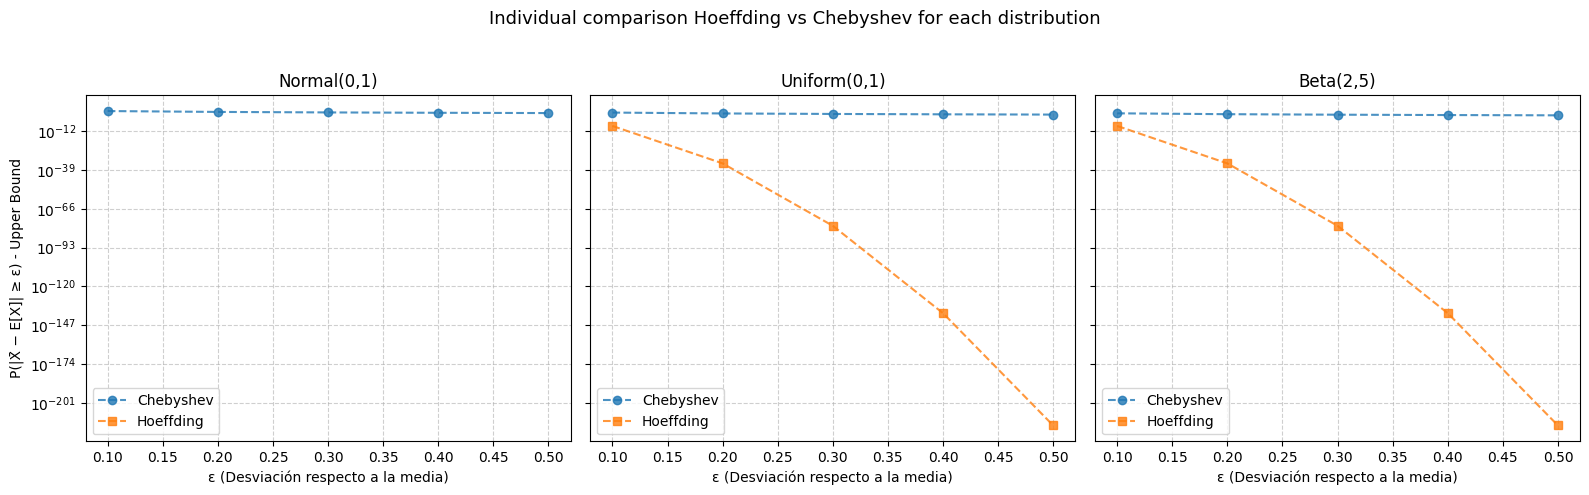

In [5]:
# --- Comparación individual de Hoeffding vs Chebyshev por distribución ---

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for ax, (name, data) in zip(axes, results.items()):
    eps_vals = [p[0] for p in data['bounds']]
    hoeff_vals = [p[1] for p in data['bounds']]
    cheb_vals = [p[2] for p in data['bounds']]

    ax.plot(eps_vals, cheb_vals, 'o--', label="Chebyshev", alpha=0.8)
    ax.plot(eps_vals, hoeff_vals, 's--', label="Hoeffding", alpha=0.8)
    
    ax.set_title(name)
    ax.set_xlabel("ε (Desviación respecto a la media)")
    ax.set_yscale('log')  # 🔹 Escala logarítmica añadida
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

axes[0].set_ylabel("P(|X̄ − E[X]| ≥ ε) - Upper Bound")

fig.suptitle("Individual comparison Hoeffding vs Chebyshev for each distribution", fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [6]:
def empirical_rule_test(data, mu, sigma):
    """Return empirical coverage for ±1σ, ±2σ, ±3σ."""
    within_1 = np.mean((data >= mu - sigma) & (data <= mu + sigma))
    within_2 = np.mean((data >= mu - 2*sigma) & (data <= mu + 2*sigma))
    within_3 = np.mean((data >= mu - 3*sigma) & (data <= mu + 3*sigma))
    return within_1, within_2, within_3

normal_data = sample_distribution('normal', n=10000, mu=0, sigma=1)
mu, sigma = np.mean(normal_data), np.std(normal_data)
emp_1, emp_2, emp_3 = empirical_rule_test(normal_data, mu, sigma)

print(f"68–95–99.7 empirical check (Normal N(0,1)):\n")
print(f"Within ±1σ: {emp_1*100:.2f}% (expected 68%)")
print(f"Within ±2σ: {emp_2*100:.2f}% (expected 95%)")
print(f"Within ±3σ: {emp_3*100:.2f}% (expected 99.7%)")


68–95–99.7 empirical check (Normal N(0,1)):

Within ±1σ: 68.31% (expected 68%)
Within ±2σ: 95.56% (expected 95%)
Within ±3σ: 99.70% (expected 99.7%)


# 🧭 Conclusions

- **Hoeffding’s inequality** gives *tighter* and *distribution-free* bounds, but it only applies to **bounded distributions** (Uniform, Beta).  
  For unbounded distributions like the Normal, it cannot be directly used.

- **Chebyshev’s inequality** applies to *any* distribution, but its bounds are generally more *loose* (less tight).

- The **68–95–99.7 rule** holds closely only for **Normal distributions**, as expected from the properties of the Gaussian curve.

- For **Uniform** and **Beta** distributions, the empirical variances differ significantly, so the empirical coverage does not follow that rule perfectly.

---

✅ With this notebook, you have demonstrated:
1. Generation of random data from various distributions.  
2. Empirical and theoretical estimation of confidence intervals.  
3. Application of Hoeffding and Chebyshev inequalities.  
4. Verification of the empirical rule.
